# NMO Filter

The normal move-out filter corrects for source-receiver antennae separation by finding the legs of the triangular travel path. Within ImpDAR, this filter also converts from two-way-travel-time to depth. Both the filter and the depth conversion account for variable wave speed when requested.

Here, we walk through an example using ground-based snow radar from South Cascade Glacier. Density cores drilled in the snowpack are used to constrain the wave speed.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import impdar

Load the raw data (PulseEkko format) and do some initial processecing steps (vertical bandpass and pretrigger crop) before considering the nmo filter.

<IPython.core.display.Javascript object>


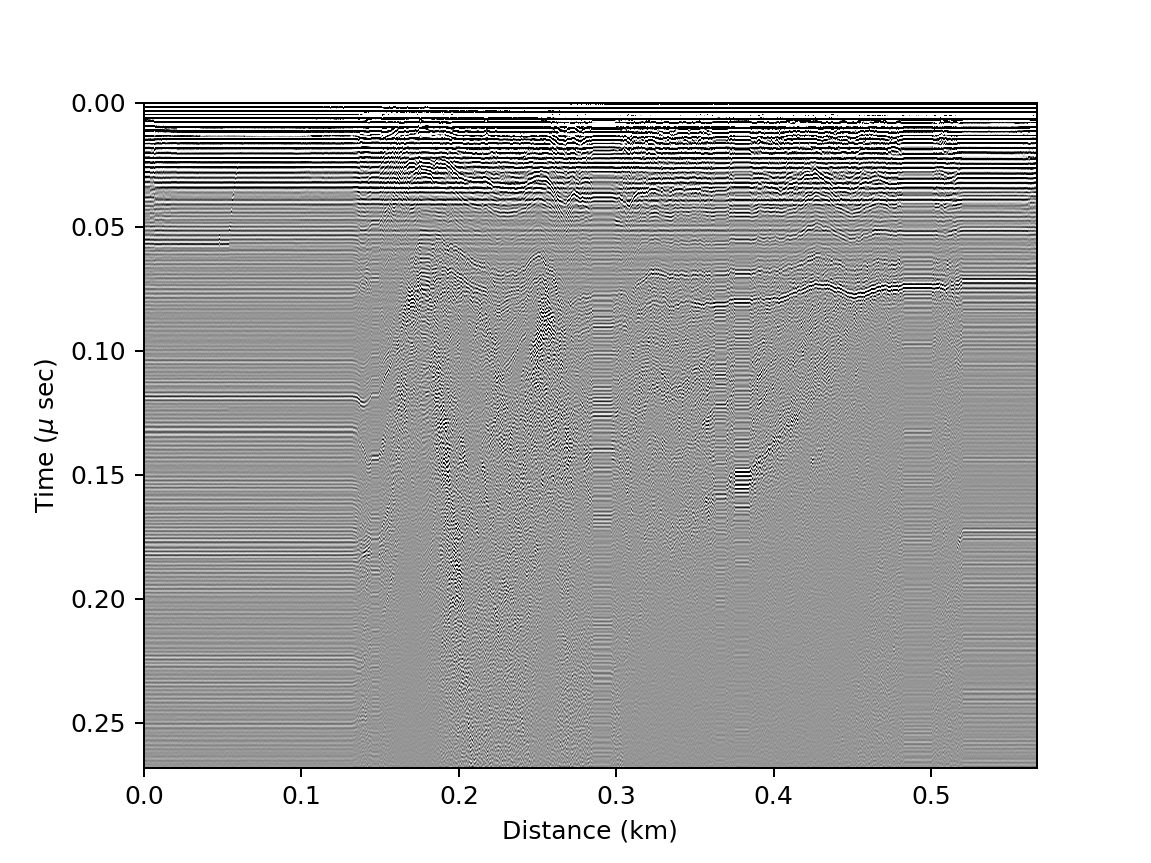

Bandpassing from 250.0 to 750.0 MHz...
Bandpass filter complete.
Vertical samples reduced to subset [317:3000] of original


In [18]:
plt.figure()

dat = impdar.load.load('pe',['LINE01.DT1'])[0]
dat.vertical_band_pass(250,750)
dat.crop(0.,dimension='pretrig')
plt.imshow(dat.data,cmap='Greys',vmin=-100,vmax=100,aspect='auto',
           extent=[min(dat.dist),max(dat.dist),max(dat.travel_time),min(dat.travel_time)])
plt.ylabel('Time ($\mu$ sec)');
plt.xlabel('Distance (km)');

plt.show()

Load and plot the vertical wave speed profile with depth. At every reflector depth for the correction, the nmo filter uses a root-mean-square wave speed to calculate the time between the two antennae. This is one leg of the triangle, the recorded time is the hypoteneuse, and the second leg is the vertical time that we really want.

<IPython.core.display.Javascript object>


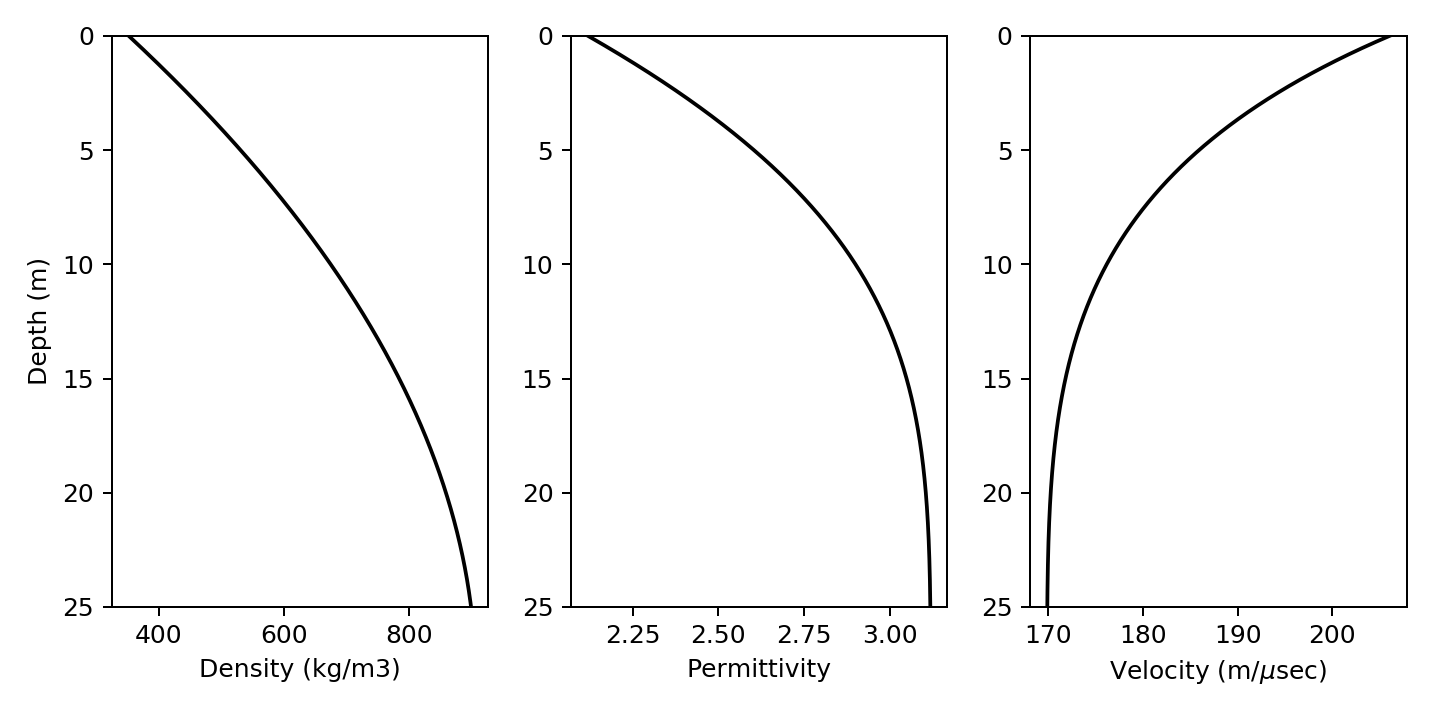

In [15]:
from impdar.lib.permittivity_models import firn_permittivity

rho_profile_data = np.genfromtxt('2018_density_profile.csv',delimiter=',')
profile_depth = rho_profile_data[:,0]
profile_rho = rho_profile_data[:,1]
profile_vel = 300./np.sqrt(np.real(firn_permittivity(profile_rho)))

plt.figure(figsize=(8,4))

ax1 = plt.subplot(131)
plt.ylabel('Depth (m)')
plt.xlabel('Density (kg/m3)')
plt.plot(profile_rho,profile_depth,'k')
plt.ylim(max(profile_depth),0)

ax2 = plt.subplot(132)
plt.xlabel('Permittivity')
plt.plot(firn_permittivity(profile_rho),profile_depth,'k')
plt.ylim(max(profile_depth),0)

ax3 = plt.subplot(133)
plt.xlabel('Velocity (m/$\mu$sec)')
plt.plot(profile_vel,profile_depth,'k')
plt.ylim(max(profile_depth),0)

plt.tight_layout()
plt.draw()

Finally, do the nmo correction. This correction stretches samples near the surface, so a 1-dimensional interpolation is done afterward to get equal depth sampling. 

You will notice that the corrected times are longer than the uncorrected times. This is because the raw times are measured at the reciever. Really though, we need the times relative to the transmit pulse for the correction. The time for the initial pulse to get to the antennae is added to the measured time to get the transmitted time and that is corrected to get the vertical leg of the triangle (the final nmo time).

<IPython.core.display.Javascript object>


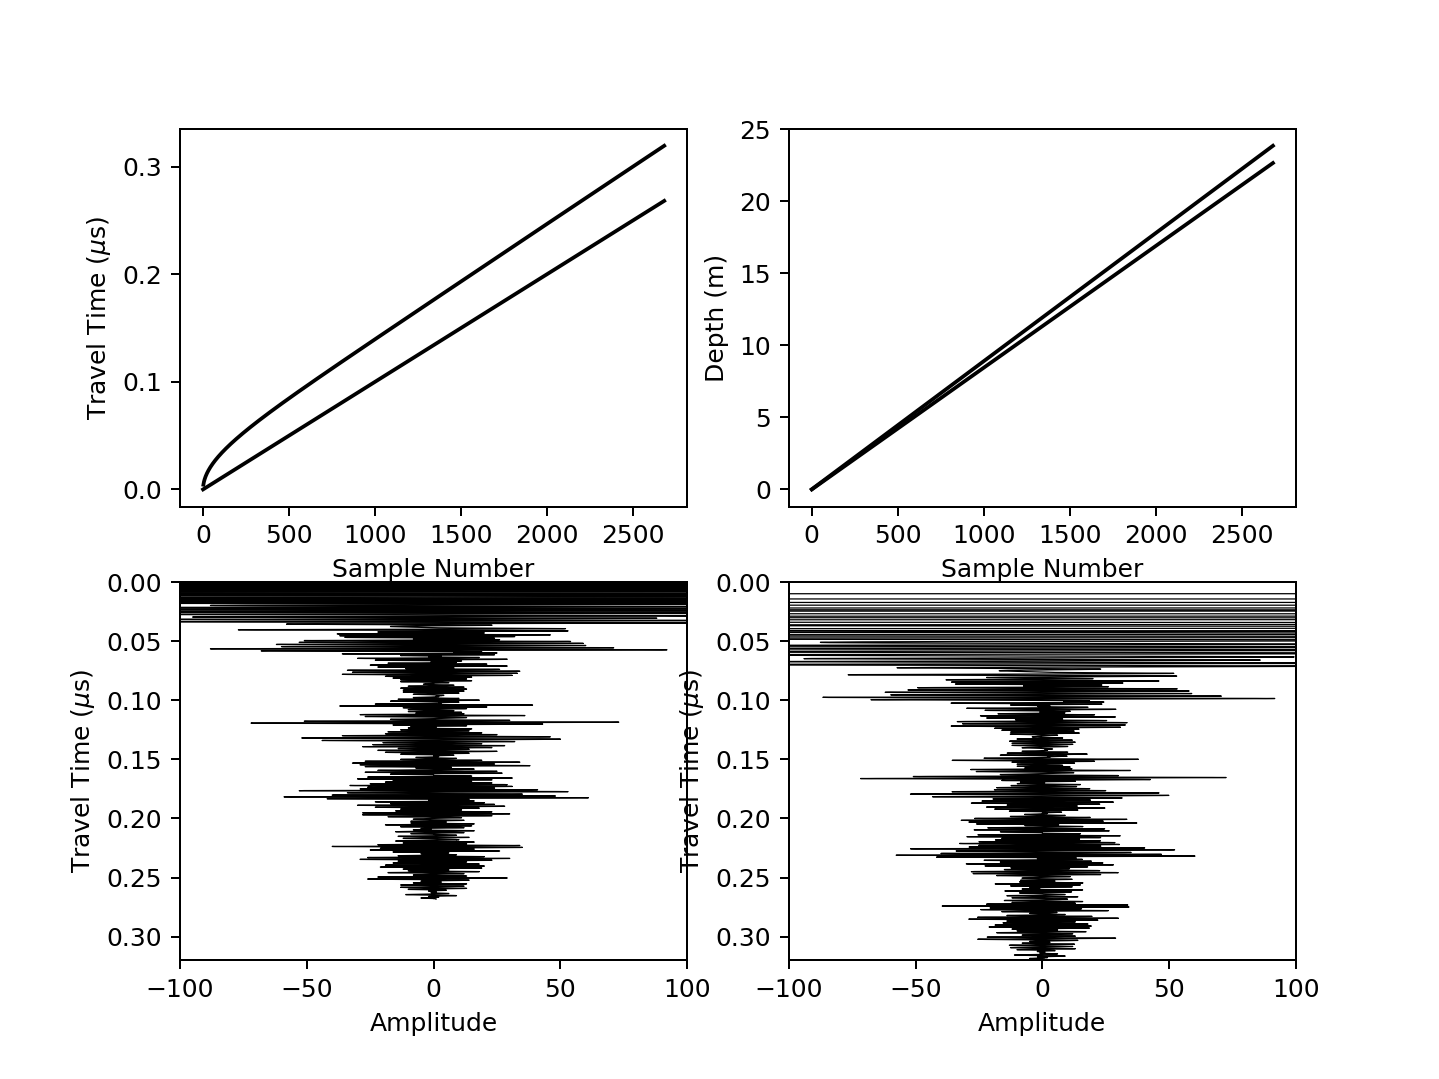

In [19]:
plt.figure(figsize=(8,6))

ax1 = plt.subplot(221)
ax1.plot(dat.travel_time,'k')
plt.xlabel('Sample Number')
plt.ylabel('Travel Time ($\mu$s)')
ax2 = plt.subplot(222)
ax2.plot(dat.travel_time/2.*169,'k')
plt.xlabel('Sample Number')
plt.ylabel('Depth (m)')

ax3 = plt.subplot(223)
plt.plot(dat.data[:,400],dat.travel_time,'k',lw=0.5)
plt.xlim(-100,100)
plt.ylim(0.32,0.0)
plt.ylabel('Travel Time ($\mu$s)')
plt.xlabel('Amplitude')

dat.nmo(10.,rho_profile='2018_density_profile.csv')

ax1.plot(dat.travel_time,'k')
ax2.plot(dat.nmo_depth,'k')

ax4 = plt.subplot(224)
plt.plot(dat.data[:,400],dat.travel_time,'k',lw=0.5)
plt.xlim(-100,100)
plt.ylim(0.32,0.0)
plt.ylabel('Travel Time ($\mu$s)')
plt.xlabel('Amplitude')

plt.show()